## random forest regression model for predicting price

In [198]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

In [199]:
X = pd.read_json('../data/model_data/X.json')
y = pd.read_json('../data/model_data/y.json', typ='series')

## some data cleaning

In [200]:
# one-hot-encode categorical features
X_encoded = pd.get_dummies(X)
X_float = X.select_dtypes(include=np.number)
X = pd.concat([X_float, X_encoded], axis=1)

In [201]:
# impute np.nan values with numerical sentinel 
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = -999)
X = imp.fit_transform(X)

In [202]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=4)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=4)

In [203]:
# oops -- impute 0 value by mean imputation
y_test[1576] = np.mean(y_test)

## hyperparameter selection

In [204]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [205]:
def calc_metrics(y_true, y_pred):
    price_pred = np.exp(y_pred)
    price_true = np.exp(y_true).to_numpy()
    
    mape = mean_absolute_percentage_error(price_true, price_pred)
    rmse_log = mean_squared_error(y_true, y_pred, squared=False) * 100
    rmse_price = mean_squared_error(price_true, price_pred, squared=False)
    
    return mape, rmse_log, rmse_price

In [210]:
# random search for hyperparameter selection
m_list, n_list = [], []
for i in range(100):
        m_list.append(random.randint(1, 50))
        n_list.append(random.randint(1, 20))

m_list.sort()

for m, n in zip(m_list, n_list):
    regr = RandomForestRegressor(max_features=m, n_estimators=n, random_state=42)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_val)
    print((m, n))
    print('\t', calc_metrics(y_val, y_pred))
    
# (m, n) = 45, 3

(1, 3)
	 (11.868127197784286, 29.813390474439544, 516.3571581690837)
(2, 14)
	 (9.332532626128096, 20.95848306565033, 540.3585664417809)
(2, 8)
	 (9.652128955686546, 22.138162373211507, 551.964298620017)
(4, 8)
	 (9.23573689549033, 19.97813794136923, 479.62163155003293)
(5, 2)
	 (10.32337961228274, 31.94618734340683, 555.9811176997027)
(5, 18)
	 (8.904972306683456, 18.84066179703354, 500.9642552978658)
(5, 19)
	 (8.918219530604595, 18.733813316590226, 492.85965054461093)
(5, 3)
	 (9.992419128064329, 25.720613973720802, 519.0243644696916)
(6, 13)
	 (9.542366558546805, 20.991449234422173, 505.9179875673234)
(6, 1)
	 (13.575443276211812, 30.23057191039954, 835.1097871032017)
(7, 7)
	 (9.352970376619394, 18.96248297198112, 492.36239212223177)
(7, 20)
	 (8.648856664154476, 18.16668606083976, 481.81159018232273)
(8, 18)
	 (9.07948437029665, 19.836967522146708, 480.7420911150541)
(8, 8)
	 (9.23863702247349, 19.928101590805532, 446.27294601068536)
(8, 12)
	 (9.2482193500273, 20.14918915647344,

In [211]:
# evaluate on test data
regr = RandomForestRegressor(max_features=45, n_estimators=3, random_state=42)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

## metrics and error visualization

In [212]:
mape, rmse_log, rmse_price = calc_metrics(y_test, y_pred)

print('MAPE:', str(mape) + '%')
print('RMSE (log):', str(rmse_log) + '%')
print('RMSE:', rmse_price)

MAPE: 11.505778770481536%
RMSE (log): 25.453144818084272%
RMSE: 440.30788171066075


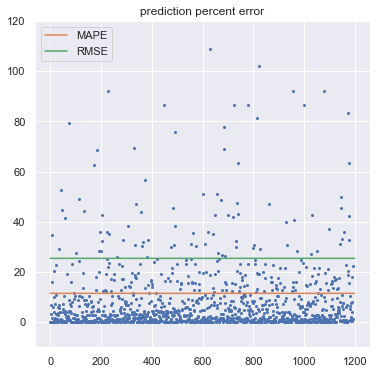

In [213]:
# visualize errors
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.subplots(figsize=(6,6))
plt.plot(np.abs(price_pred - price_true) / price_true * 100, 'o', markersize=2)
plt.plot(np.arange(1200), [mape] * 1200, label='MAPE')
plt.plot(np.arange(1200), [rmse_log] * 1200, label='RMSE')
plt.title('prediction percent error')
plt.ylim(-10, 120) # note: 3 outliers are not visible
plt.legend()
plt.savefig('error.png', dpi=300)